In [2]:
import dice_ml
# import importlib
import dice_ml.explainer_interfaces.dice_tensorflow2 
import keras

from dice_ml.utils import helpers # helper functions
from sklearn.model_selection import train_test_split

dataset = helpers.load_adult_income_dataset()
target = dataset["income"] # outcome variable
train_dataset, test_dataset, _, _ = train_test_split(dataset,
                                                     target,
                                                     test_size=0.2,
                                                     random_state=0,
                                                     stratify=target)
# Dataset for training an ML model
d = dice_ml.Data(dataframe=train_dataset,
                 continuous_features=['age', 'hours_per_week'],
                 outcome_name='income')

# Pre-trained ML model
m = dice_ml.Model(model_path=dice_ml.utils.helpers.get_adult_income_modelpath(),
                  backend='TF2', func="ohe-min-max")
# DiCE explanation instance
exp = dice_ml.Dice(d,m)

100%|██████████| 10/10 [02:55<00:00, 17.56s/it]


Avg L2 Distance (Gelbrich CFs, Age ≤ 40): 2.4636252123876057
Avg L2 Distance (Gelbrich CFs, Age > 40): 2.2167934621334826
Avg L2 Distance (L2 CFs, Age ≤ 40): 2.458400960770235
Avg L2 Distance (L2 CFs, Age > 40): 2.230871889014749


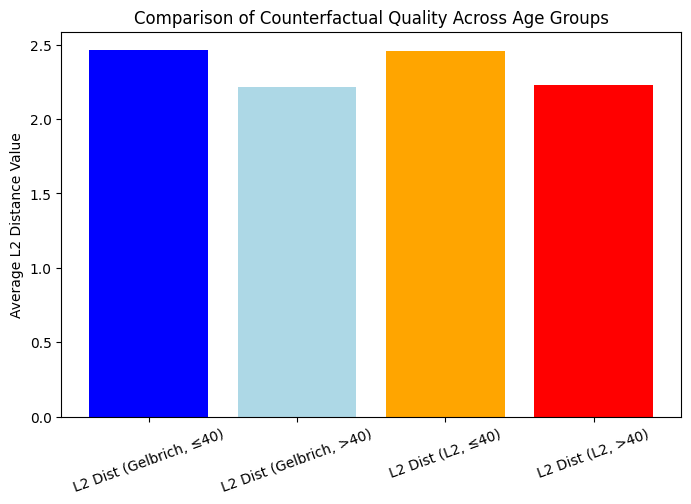

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import dice_ml
import tensorflow as tf
import numpy as np
from scipy.linalg import sqrtm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from dice_ml.utils import helpers  # Helper functions

# **Step 1: Load and Sort Dataset by Age**
dataset = helpers.load_adult_income_dataset()
dataset = dataset.sort_values(by="age")  # Sort by age
target = dataset["income"]  # Outcome variable

# **Step 2: Split Dataset**
train_dataset, test_dataset, _, _ = train_test_split(
    dataset, target, test_size=0.2, random_state=0, stratify=target
)

# **Step 3: Define Age Groups**
test_below_40 = test_dataset[test_dataset["age"] <= 40]
test_above_40 = test_dataset[test_dataset["age"] > 40]

# **Step 4: Create DiCE Data Interface**
d = dice_ml.Data(
    dataframe=train_dataset,
    continuous_features=['age', 'hours_per_week'],
    outcome_name='income'
)

# **Step 5: Load Pre-trained ML Model**
m = dice_ml.Model(
    model_path=dice_ml.utils.helpers.get_adult_income_modelpath(),
    backend='TF2', func="ohe-min-max"
)

# **Step 6: Initialize DiCE Explainer**
exp = dice_ml.Dice(d, m)

# 🔹 **Step 7: Modify DiCE for L2 Counterfactual Generation**
orig_compute_proximity_loss = dice_ml.explainer_interfaces.dice_tensorflow2.DiceTensorFlow2.compute_proximity_loss

def compute_l2_proximity(self):
    """Compute L2 (Euclidean) distance"""
    proximity_loss = 0.0
    for i in range(self.total_CFs):
        proximity_loss += tf.norm(self.cfs[i] - self.x1, ord=2)  # Euclidean distance
    return proximity_loss / tf.cast((tf.multiply(len(self.minx[0]), self.total_CFs)), dtype=tf.float32)

def compute_l2_diversity(self):
    """Compute diversity loss using L2 distance"""
    if self.total_CFs == 1:
        return tf.constant(0.0)

    diversity_loss = 0.0
    count = 0.0
    for i in range(self.total_CFs):
        for j in range(i+1, self.total_CFs):
            count += 1.0
            diversity_loss += 1.0/(1.0 + tf.norm(self.cfs[i] - self.cfs[j], ord=2))  # Use Euclidean instead of Gelbrich
    return 1.0 - (diversity_loss/count)

def dpp_style_l2(self, submethod):
    """Compute Determinant Point Process (DPP) using L2 distances instead of Gelbrich."""
    det_entries = []
    for i in range(self.total_CFs):
        for j in range(self.total_CFs):
            det_temp_entry = tf.divide(1.0, tf.add(
                1.0, tf.norm(self.cfs[i] - self.cfs[j], ord=2)))  # Use L2 distance here
            if i == j:
                det_temp_entry = tf.add(det_temp_entry, 0.0001)
            det_entries.append(det_temp_entry)

    det_entries = tf.reshape(det_entries, [self.total_CFs, self.total_CFs])
    diversity_loss = tf.compat.v1.matrix_determinant(det_entries)
    return diversity_loss

# **Override Default Methods with L2 Versions**


# 🔹 **Step 8: Function to Generate Counterfactuals & Compute L2 Distances**
def compute_l2_distance(test_data, cf_type="L2"):
    """Generate counterfactuals and compute L2 distances for a given test dataset."""
    
    query_instance = test_data.drop(columns="income")[0:10]  # Select first 10 instances

    # Generate Counterfactuals (Gelbrich vs L2)
    if cf_type == "Gelbrich":
        dice_exp = exp.generate_counterfactuals(query_instance, total_CFs=200, desired_class="opposite")
    else:
        # Temporarily replace with L2-based proximity loss
        dice_ml.explainer_interfaces.dice_tensorflow2.DiceTensorFlow2.dpp_style = dpp_style_l2
        dice_ml.explainer_interfaces.dice_tensorflow2.DiceTensorFlow2.compute_diversity_loss = compute_l2_diversity
        dice_ml.explainer_interfaces.dice_tensorflow2.DiceTensorFlow2.compute_proximity_loss = compute_l2_proximity
        dice_exp = exp.generate_counterfactuals(query_instance, total_CFs=200, desired_class="opposite")
        # Restore original Gelbrich loss
        dice_ml.explainer_interfaces.dice_tensorflow2.DiceTensorFlow2.compute_proximity_loss = orig_compute_proximity_loss

    # One-Hot Encode Features
    encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    encoder.fit(train_dataset.drop(columns=['income']))  

    query_encoded = encoder.transform(query_instance).astype(float)

    all_l2_distances = []

    for idx in range(len(query_instance)):  
        cf_data = dice_exp.cf_examples_list[idx].final_cfs_df.drop(columns=['income'])
        cf_encoded = encoder.transform(cf_data).astype(float)

        query_instance_np = query_encoded[idx].reshape(1, -1)

        # Compute L2 distance (for evaluation only)
        l2_distances = [np.linalg.norm(cf - query_instance_np) for cf in cf_encoded]
        all_l2_distances.append(np.mean(l2_distances))

    return np.mean(all_l2_distances)

# 🔹 **Step 9: Compute L2 Distances for Both Methods Across Age Groups**
l2_dist_below_40_from_gelbrich = compute_l2_distance(test_below_40, cf_type="Gelbrich")
l2_dist_above_40_from_gelbrich = compute_l2_distance(test_above_40, cf_type="Gelbrich")
l2_dist_below_40_from_l2 = compute_l2_distance(test_below_40, cf_type="L2")
l2_dist_above_40_from_l2 = compute_l2_distance(test_above_40, cf_type="L2")

# 🔹 **Step 10: Compare the Results**
print(f"Avg L2 Distance (Gelbrich CFs, Age ≤ 40): {l2_dist_below_40_from_gelbrich}")
print(f"Avg L2 Distance (Gelbrich CFs, Age > 40): {l2_dist_above_40_from_gelbrich}")
print(f"Avg L2 Distance (L2 CFs, Age ≤ 40): {l2_dist_below_40_from_l2}")
print(f"Avg L2 Distance (L2 CFs, Age > 40): {l2_dist_above_40_from_l2}")

# 🔹 **Step 11: Plot the Results**
labels = [
    "L2 Dist (Gelbrich, ≤40)", "L2 Dist (Gelbrich, >40)", 
    "L2 Dist (L2, ≤40)", "L2 Dist (L2, >40)"
]
values = [
    l2_dist_below_40_from_gelbrich, l2_dist_above_40_from_gelbrich, 
    l2_dist_below_40_from_l2, l2_dist_above_40_from_l2
]

plt.figure(figsize=(8, 5))
plt.bar(labels, values, color=['blue', 'lightblue', 'orange', 'red'])
plt.ylabel("Average L2 Distance Value")
plt.title("Comparison of Counterfactual Quality Across Age Groups")
plt.xticks(rotation=20)
plt.show()
